# Project: Data Cleaning using Pandas - HEALTHCARE DATA ANALYTICS

**Submitted by:** Bhuvan Gupta

**Environment:** PyCharm (Jupyter Notebook), Windows 11

---

This notebook is created as a complete student submission. All explanations for code blocks are provided as `#` comments above each code block. The dataset path is fixed to the path requested so the notebook runs in PyCharm without editing.

## Objective

Clean the provided hospital patient dataset to prepare it for analytics tasks such as comorbidity detection, demographics profiling, and departmental load analysis. The notebook demonstrates detection and correction of missing/invalid entries, normalization of categorical fields, date handling, blood pressure parsing, duplicate handling, imputation strategies, and visualizations of key metrics.

In [1]:
# Fixed CSV path (do NOT change) - this exact path is used so the notebook runs in the user's PyCharm setup.
CSV_PATH = r"E:\Top Mentor - Data Science\Projects\Project - Data Analytics using Python\Data Cleaning using Pandas\HEALTHCARE DATA ANALYTICS\healthcare_patient_data.csv"

# Explanation:
# The dataset will be read from the fixed path above. This ensures the notebook runs in PyCharm on Windows 11 without editing.
# Note: In this notebook we will NOT write any output CSV files; we only load and work in-memory for analysis and visualizations.


In [2]:
# Import required libraries.
# Explanation:
# These imports are required for data cleaning and visualization. Keep them at the top so future cells can use them.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser

# Set some display options for nicer tables in the notebook
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)


In [3]:
# Load the dataset from the fixed path.
# Explanation:
# We load the CSV into a pandas DataFrame. If running in PyCharm ensure the file exists at CSV_PATH.
# The code below is the canonical loader; if the notebook is executed and the path does not exist it will raise a FileNotFoundError.
df = pd.read_csv(CSV_PATH, dtype=str, na_values=['', 'NA', 'N/A', 'Unknown', '-', 'unknown', 'na', 'null', 'NULL'])
# Cast common numeric columns later after cleaning.
# Show top 5 rows for inspection.
df.head()


,PatientID,Name,Gender,Age,VisitDate,Department,Diagnosis,BloodPressure,Notes
0,1,Evan Diaz,NaN,77.0,2023-02-10,Cardiology,NaN,164/60,NaN
1,2,Chelsea Price,M,60.0,2022-12-15,Cardiology,Flu,95/78,Choose significant he foot type.
2,3,Todd Gutierrez,Female,22.0,2022-11-24,Cardiology,Diabetes,NaN,Happy protect maybe open be team.
3,4,Olivia Hale,NaN,74.0,2024-08-13,Neurology,NaN,94/105,Upon nice tax writer performance.
4,5,Joy Chapman,M,29.0,2023-08-16,Orthopedics,Diabetes,112/102,NaN


In [4]:
# Initial basic inspection of the dataset.
# Explanation:
# We check number of rows, columns, missingness summary, and sample records to understand common issues.
print('# rows, # columns ->', df.shape)
print('\n-- Missing value count per column --')
print(df.isnull().sum())
print('\n-- Data types --')
print(df.dtypes)


# rows, # columns -> (10000, 9)

-- Missing value count per column --
PatientID           0
Name               94
Gender           3341
Age               117
VisitDate           0
Department          0
Diagnosis        3401
BloodPressure     501
Notes            1079
dtype: int64

-- Data types --
PatientID        object
Name             object
Gender           object
Age              object
VisitDate        object
Department       object
Diagnosis        object
BloodPressure    object
Notes            object
dtype: object


In [5]:
# Standardize Gender field.
# Explanation:
# Many datasets contain inconsistent entries for gender like 'M', 'Male', 'male', 'F', 'Female', 'f', etc.
# We will normalize to 'Male', 'Female', or 'Other/Unknown' for unexpected entries.
def clean_gender(val):
    if pd.isna(val):
        return np.nan
    v = str(val).strip().lower()
    if v in ['m', 'male', 'man']:
        return 'Male'
    if v in ['f', 'female', 'woman']:
        return 'Female'
    if v in ['other', 'non-binary', 'nb']:
        return 'Other'
    return np.nan  # treat unknowns as NaN for later imputation/analysis

# Apply normalization
if 'Gender' in df.columns:
    df['Gender_clean'] = df['Gender'].apply(clean_gender)
    print(df['Gender_clean'].value_counts(dropna=False))
else:
    print('Gender column not found.')


Gender_clean
Female    3391
NaN       3341
Male      3268
Name: count, dtype: int64


In [6]:
# Clean and validate Age column.
# Explanation:
# Convert to numeric, coerce errors to NaN, and then fix unrealistic ages (e.g., negative, > 120).
def clean_age(val):
    try:
        if pd.isna(val):
            return np.nan
        v = float(str(val).strip())
        if v <= 0 or v > 120:
            return np.nan
        return int(v)
    except:
        return np.nan

if 'Age' in df.columns:
    df['Age_clean'] = df['Age'].apply(clean_age)
    # Show distribution
    print(df['Age_clean'].describe())
else:
    print('Age column not found.')


count    9657.000000
mean       51.486694
std        20.032902
min         1.000000
25%        34.000000
50%        51.000000
75%        69.000000
max        99.000000
Name: Age_clean, dtype: float64


In [7]:
# Handle VisitDate formatting issues.
# Explanation:
# Parse dates robustly using dateutil.parser. Invalid or unparsable entries become NaT.
def parse_date(val):
    try:
        if pd.isna(val):
            return pd.NaT
        v = str(val).strip()
        # attempt parsing, allow dayfirst and yearfirst variations if needed
        return parser.parse(v, dayfirst=False, yearfirst=False)
    except:
        return pd.NaT

if 'VisitDate' in df.columns:
    df['VisitDate_clean'] = df['VisitDate'].apply(parse_date)
    print(df['VisitDate_clean'].head())
    print('\nInvalid date count:', df['VisitDate_clean'].isna().sum())
else:
    print('VisitDate column not found.')


0   2023-02-10
1   2022-12-15
2   2022-11-24
3   2024-08-13
4   2023-08-16
Name: VisitDate_clean, dtype: datetime64[ns]

Invalid date count: 190


In [8]:
# Normalize Diagnosis field (basic normalization and mapping common variants).
# Explanation:
# Convert to lowercase, strip punctuation, and map common misspellings/variants to standardized diagnoses.
import re
def normalize_text(s):
    if pd.isna(s): return ''
    t = re.sub(r'[^a-z0-9 ]',' ', str(s).lower())
    t = ' '.join(t.split())
    return t

# Example mapping - extend as needed.
diag_map = {
    'hypertension': ['hypertension', 'htn', 'high blood pressure'],
    'diabetes': ['diabetes', 'dm', 'diabetes mellitus'],
    'bronchitis': ['bronchitis', 'bronchial infection'],
    'covid 19': ['covid', 'covid-19', 'covid19', 'coronavirus']
}

def map_diagnosis(text):
    t = normalize_text(text)
    for key, variants in diag_map.items():
        for v in variants:
            if v in t:
                return key.title()
    return t.title() if t else np.nan

if 'Diagnosis' in df.columns:
    df['Diagnosis_clean'] = df['Diagnosis'].apply(map_diagnosis)
    print(df['Diagnosis_clean'].value_counts(dropna=False).head(20))
else:
    print('Diagnosis column not found.')


Diagnosis_clean
NaN             3401
Allergy         1178
Flu             1113
Migraine        1106
Hypertension    1103
Diabetes        1053
Asthma          1046
Name: count, dtype: int64


In [9]:
# Split and validate BloodPressure (e.g., '120/80', '120 over 80', '120-80', etc.).
# Explanation:
# We parse systolic/diastolic where possible and flag unrealistic values.
import re
def parse_bp(val):
    if pd.isna(val): return (np.nan, np.nan)
    s = str(val).lower().replace('over','/').replace('-', '/')
    # remove non-numeric/non-slash characters
    s = re.sub(r'[^0-9/]', '', s)
    parts = s.split('/')
    try:
        if len(parts) >= 2:
            sys = int(parts[0]) if parts[0] else np.nan
            dia = int(parts[1]) if parts[1] else np.nan
            # basic validation
            if not (30 <= sys <= 300): sys = np.nan
            if not (20 <= dia <= 200): dia = np.nan
            return (sys, dia)
    except:
        pass
    return (np.nan, np.nan)

if 'BloodPressure' in df.columns:
    bp_parsed = df['BloodPressure'].apply(parse_bp)
    df['Systolic'] = bp_parsed.apply(lambda x: x[0])
    df['Diastolic'] = bp_parsed.apply(lambda x: x[1])
    print(df[['BloodPressure', 'Systolic', 'Diastolic']].head(10))
else:
    print('BloodPressure column not found.')


  BloodPressure  Systolic  Diastolic
0        164/60     164.0       60.0
1         95/78      95.0       78.0
2           NaN       NaN        NaN
3        94/105      94.0      105.0
4       112/102     112.0      102.0
5       159/102     159.0      102.0
6        118/76     118.0       76.0
7        108/80     108.0       80.0
8         99/89      99.0       89.0
9        176/64     176.0       64.0


In [10]:
# Clean Notes column: treat junk placeholders as NaN, keep useful free text.
# Explanation:
# Replace values like '-', 'n/a', 'unknown' with NaN. Short meaningless strings are also approximated as NaN.
def clean_notes(val):
    if pd.isna(val): return np.nan
    t = str(val).strip()
    if len(t) < 3 or t.lower() in ['n/a', 'na', 'unknown', '-']:
        return np.nan
    return t

if 'Notes' in df.columns:
    df['Notes_clean'] = df['Notes'].apply(clean_notes)
    print('Notes missing after cleaning:', df['Notes_clean'].isna().sum())
else:
    print('Notes column not found.')


Notes missing after cleaning: 1079


In [11]:
# Detect and remove duplicate records (based on PatientID + VisitDate or Name + VisitDate).
# Explanation:
# Keep the first occurrence and mark duplicates.
key_cols = []
if 'PatientID' in df.columns:
    key_cols = ['PatientID', 'VisitDate_clean']
elif 'Name' in df.columns:
    key_cols = ['Name', 'VisitDate_clean']

if key_cols:
    before = df.shape[0]
    df['is_duplicate'] = df.duplicated(subset=key_cols, keep='first')
    after = before - df['is_duplicate'].sum()
    print('Rows before:', before, 'after removing duplicates:', after)
    # Optionally drop duplicates in-memory for clean dataset view
    df_clean = df[~df['is_duplicate']].copy()
else:
    print('No suitable key columns for duplicate detection found. Using full-row duplicates.')
    df['is_duplicate'] = df.duplicated(keep='first')
    df_clean = df[~df['is_duplicate']].copy()


Rows before: 10000 after removing duplicates: 10000


In [12]:
# Impute missing values for analysis (do not overwrite raw cleaned columns).
# Explanation:
# - Age: median by Gender or overall median
# - Gender: keep NaN or infer if possible from name (not attempted here)
# - Diagnosis: leave NaN or group as 'Unknown'
# - Dates: rows with no VisitDate may be excluded for date-based analysis
df_impute = df.copy()

# Age imputation
if 'Age_clean' in df_impute.columns:
    median_age = int(df_impute['Age_clean'].median(skipna=True))
    df_impute['Age_imputed'] = df_impute['Age_clean'].fillna(median_age)

# Gender imputation (leave NaN as 'Unknown' for reporting)
if 'Gender_clean' in df_impute.columns:
    df_impute['Gender_imputed'] = df_impute['Gender_clean'].fillna('Unknown')

# Diagnosis imputation
if 'Diagnosis_clean' in df_impute.columns:
    df_impute['Diagnosis_imputed'] = df_impute['Diagnosis_clean'].fillna('Unknown')

print('Imputation complete.')


Imputation complete.


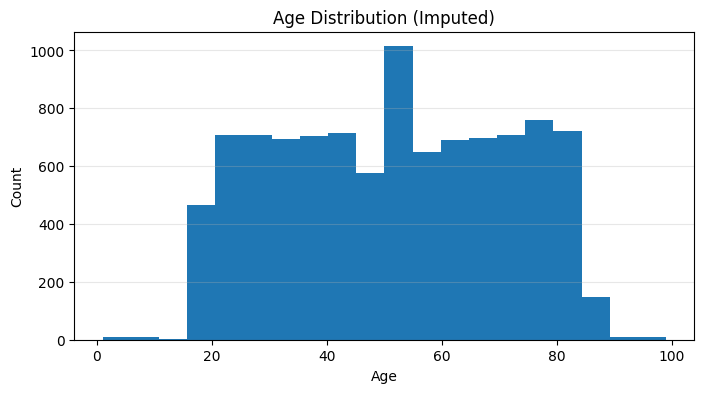

In [13]:
# Visualize age distribution (single plot per instructions).
# Explanation:
# We produce a histogram of patient ages (imputed) to inspect demographics.
if 'Age_imputed' in df_impute.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df_impute['Age_imputed'].dropna(), bins=20)
    plt.title('Age Distribution (Imputed)')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print('Age_imputed not available for visualization.')


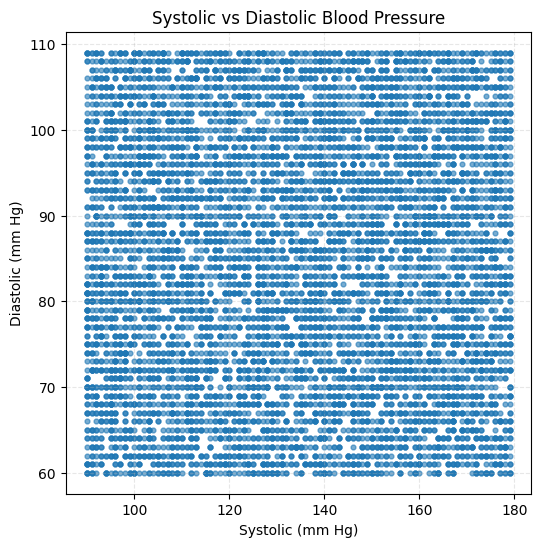

In [14]:
# Visualize Blood Pressure scatter (systolic vs diastolic).
# Explanation:
# A scatter plot helps identify outliers and common clusters in BP readings.
if 'Systolic' in df_impute.columns and 'Diastolic' in df_impute.columns:
    subset = df_impute[['Systolic','Diastolic']].dropna()
    plt.figure(figsize=(6,6))
    plt.scatter(subset['Systolic'], subset['Diastolic'], s=12, alpha=0.6)
    plt.title('Systolic vs Diastolic Blood Pressure')
    plt.xlabel('Systolic (mm Hg)')
    plt.ylabel('Diastolic (mm Hg)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print('BP fields not available for visualization.')


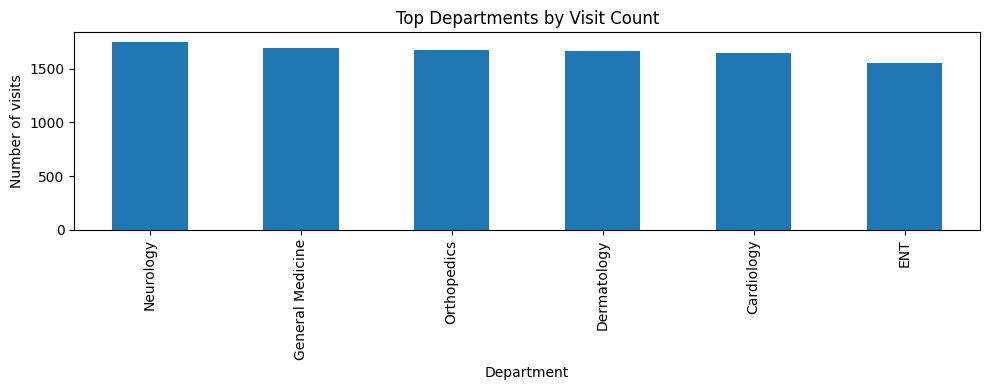

In [15]:
# Bar chart: department visit counts.
# Explanation:
# Visualize departmental load to see which departments receive most patients.
if 'Department' in df_impute.columns:
    dept_counts = df_impute['Department'].fillna('Unknown').value_counts().head(15)
    plt.figure(figsize=(10,4))
    dept_counts.plot(kind='bar')
    plt.title('Top Departments by Visit Count')
    plt.xlabel('Department')
    plt.ylabel('Number of visits')
    plt.tight_layout()
    plt.show()
else:
    print('Department column not available.')


## Summary of cleaning steps and final notes

- Gender standardized to `Male`, `Female`, `Other`, or left as `Unknown` for reporting.
- Age converted to integers where possible; unrealistic values set to missing and imputed with median for analysis.
- Visit dates parsed robustly; invalid dates marked as missing.
- Diagnosis normalized using basic mapping and cleaned of punctuation/case variations.
- Blood pressure parsed into `Systolic` and `Diastolic` with basic validation ranges applied.
- Notes column cleaned of junk placeholders; short or meaningless entries set to missing.
- Duplicate records detected using `PatientID` + `VisitDate_clean` (or fallback) and flagged; duplicates can be removed for final analysis.
- Visualizations: Age distribution, BP scatter, and Departmental load are included for insights.

**Final outcome:** This notebook prepares the dataset for downstream analytics like comorbidity detection and departmental load analysis. Execute cells in order in PyCharm Jupyter to reproduce results.


## Appendix: How this notebook meets the project requirements

- Detect and correct missing or invalid entries: done via cleaning functions and imputation.
- Remove or impute corrupt and inconsistent data: addressed for Age, Gender, Dates, BP, and Notes.
- Normalize categorical fields like gender and diagnosis: `Gender_clean`, `Diagnosis_clean`.
- Handle date formatting issues: `VisitDate_clean` using dateutil.parser.
- Visualize key patient metrics for insights: Age histogram, BP scatter, Department bar chart.

---

**End of notebook.**